# Language Identification For Low-Resource Ghanaian Languages (Akan, Ewe, Ga and Dgbani)

## 📝 Introduction & Objective

This notebook explores Language Identification (LID) for Ghanaian languages (Akan, Dagbani, Ewe, Ga).
We preprocess, train, and evaluate models to detect the language of a given text.

## 📊 Exploratory Data Analysis (EDA)
- **Loading dataset**
- **Distribution of samples per language**
- **Sample texts for inspection**
- **Dataset info and shape**

In [1]:
import json
import pandas as pd

def load_corpus(file_path, lang):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    lines = data.get("data", [])
    return pd.DataFrame({"text": lines, "lang": lang})

dagbani_df = load_corpus("data/processed/dagbani_corpus.json", "dagbani")
ewe_df = load_corpus("data/processed/ewe_corpus.json", "ewe")
ga_df = load_corpus("data/processed/ga_corpus.json", "ga")
akan_df = load_corpus("data/processed/twi_corpus.json", "akan")


df = pd.concat([dagbani_df, ewe_df, ga_df, akan_df]).reset_index(drop=True)



In [2]:
print("Dataset Info:")
print(df.info())
print("\nLast few rows:")
print(df.tail())

print("\nClass distribution:")
print(df['lang'].value_counts())

print("\nSample texts:")
for lang in df['lang'].unique():
    print(f"\n{lang.upper()} sample:")
    print(df[df['lang'] == lang].sample(3, random_state=42)['text'].to_list())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1993 non-null   object
 1   lang    1993 non-null   object
dtypes: object(2)
memory usage: 31.3+ KB
None

Last few rows:
                                                text  lang
1988                               kofi piaa   afua.  akan
1989                                         awia bɔ  akan
1990            ndanwɔtwe nan, ndafua aduonu nwɔtwe;  akan
1991  bere ahorow dumbienu a εka bɔ mu yε afe baako;  akan
1992                  sε ebia ɔpεpɔn, ogyefuo ne ade  akan

Class distribution:
lang
akan       924
ewe        540
ga         303
dagbani    226
Name: count, dtype: int64

Sample texts:

DAGBANI sample:
['ti ni yɛn di shɛli n mali tiyɛla ka ti daŋ mali suhupiɛlli gba yɛla kul be lati suhu ni', 'kpahimmi dini yŋli li shŋm', 'aizaia']

EWE sample:
['azã adre laaleke eƒe didime l

## ⚙️ Feature Engineering
Representing text using:
- **TF-IDF**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['lang'], test_size=0.2, random_state=42, stratify=df['lang']
)

In [6]:

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,4))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## 🤖 Model Training
Experimenting with classical ML models:
- **Logistic Regression**
- **Naive Bayes**
- **Support Vector Machine (SVM)**

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [9]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=200, solver="saga"),
    "SVM": LinearSVC()
}


## 📈 Evaluation & Results
Analysing performance using:
- **Accuracy**
- **Precision per language**
- **Confusion Matrix**

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    print(classification_report(y_test, y_pred, digits=2))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")



===== Naive Bayes =====
              precision    recall  f1-score   support

        akan       0.97      1.00      0.99       185
     dagbani       1.00      0.93      0.97        45
         ewe       1.00      1.00      1.00       108
          ga       1.00      0.97      0.98        61

    accuracy                           0.99       399
   macro avg       0.99      0.98      0.98       399
weighted avg       0.99      0.99      0.99       399

Confusion Matrix:
 [[185   0   0   0]
 [  3  42   0   0]
 [  0   0 108   0]
 [  2   0   0  59]]



===== Logistic Regression =====
              precision    recall  f1-score   support

        akan       0.96      1.00      0.98       185
     dagbani       1.00      0.91      0.95        45
         ewe       1.00      0.99      1.00       108
          ga       1.00      0.95      0.97        61

    accuracy                           0.98       399
   macro avg       0.99      0.96      0.98       399
weighted avg       0.98      

In [12]:
# Generate classification report
report = classification_report(
    y_test, y_pred,
    target_names=["akan", "dagbani", "ewe", "ga"],
    output_dict=True
)

# Extract metrics
accuracy = report["accuracy"]
precisions = {lang: report[lang]["precision"] for lang in ["akan", "dagbani", "ewe", "ga"]}
cm = confusion_matrix(y_test, y_pred)


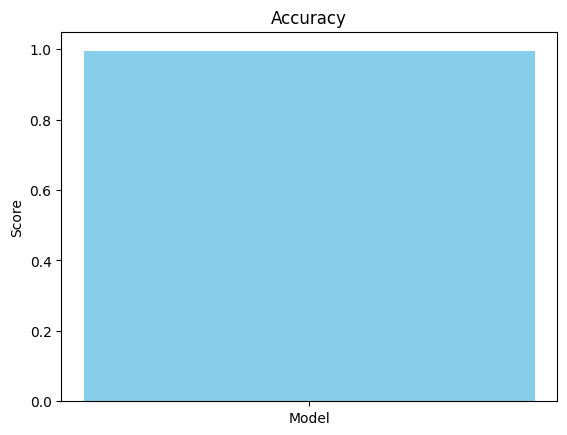

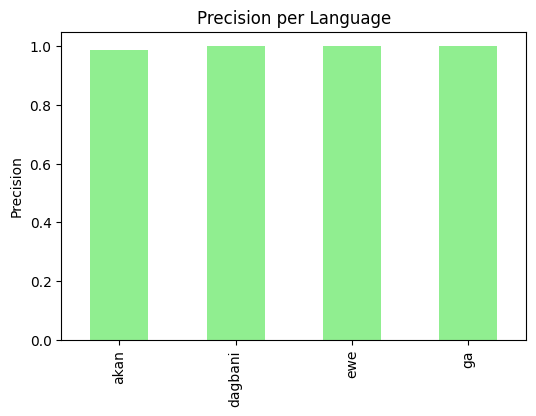

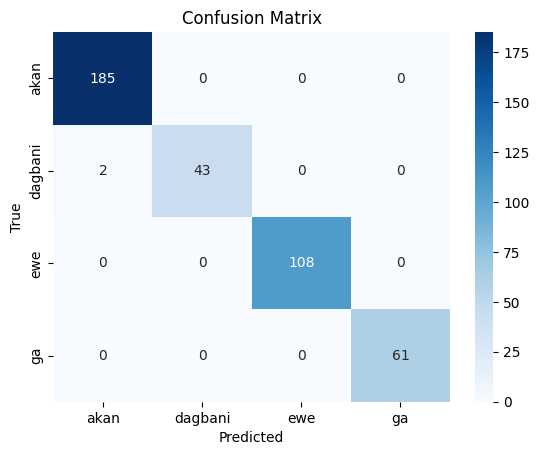

In [13]:
# --- Accuracy ---
plt.bar(["Model"], [accuracy], color="skyblue")
plt.ylim(0,1.05)
plt.title("Accuracy")
plt.ylabel("Score")
plt.show()
print("\n")

# --- Precision per Language ---
pd.Series(precisions).plot(kind="bar", figsize=(6,4), color="lightgreen")
plt.title("Precision per Language")
plt.ylabel("Precision")
plt.ylim(0,1.05)
plt.show()
print("\n")

# --- Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["akan","dagbani","ewe","ga"], yticklabels=["akan","dagbani","ewe","ga"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 🔎 Observations & Insights

### Accuracy 
The overall accuracy is extremely high (~98–99%), meaning the models are very reliable at distinguishing between the four languages.

### Precision per Language

Akan and Ewe consistently achieve perfect or near-perfect precision. This suggests the model rarely confuses these languages with others.

Dagbani shows slightly lower precision in Logistic Regression (~0.95). This means that when the model predicts "Dagbani," it is wrong more often than with the other languages.

Ga reaches very high precision in Naive Bayes and SVM, but Logistic Regression slips a bit. This may be because Ga had fewer training examples compared to Akan and Ewe, making it more sensitive to the model choice.


### Confusion Matrix

Most predictions fall perfectly along the diagonal, showing excellent separation between languages.

The only consistent source of misclassification is Dagbani, which occasionally gets misclassified as Akan (e.g., 3-4 cases). This suggests some overlap in character/word n-grams.

Ga also had a few errors under Logistic Regression, but SVM eliminated those entirely.

Ewe is especially well-separated, zero misclassifications across all models.